In [1]:
import sys
import numpy as np
import gzip
import pickle
from collections import defaultdict
import copy

def load(networkx_path):
    with gzip.open(networkx_path, 'rb') as f:
        G = pickle.load(f)
    return G

In [2]:
G_local = load('../graph_grc_pc_synapse_210429_coalesced.gz')
G_remote = load('../graph_pfs_pc_synapse_210429_coalesced.gz')

Comparing # of synapses made onto PCs by local and remote GrCs.

In [3]:
# print cell types in the graphs
cell_types = set()
for n in G_local.nodes():
    if 'cell_type' not in G_local.nodes[n]:
        continue
    cell_types.add(G_local.nodes[n]['cell_type'])
print(f'Local: {cell_types}')
cell_types = set()
for n in G_remote.nodes():
    if 'cell_type' not in G_remote.nodes[n]:
        continue
    cell_types.add(G_remote.nodes[n]['cell_type'])
print(f'Remote: {cell_types}')

Local: {'dendrite_fragment', 'grc', 'pc'}
Remote: {'cf', 'dendrite_fragment', 'pf', 'pc'}


In [4]:
# Fileter and get cell lists
local_grcs = []
remote_grcs = []
all_pcs = set()

def process_graph(G):
    for n in G.nodes():
        if 'cell_type' not in G.nodes[n]:
            continue
        cell_type = G.nodes[n]['cell_type']
        if cell_type == 'grc':
            local_grcs.append(n)
        elif cell_type == 'pf':
            remote_grcs.append(n)
        if cell_type == 'pc' or cell_type == 'dendrite_fragment':
            all_pcs.add(n)

process_graph(G_local)
process_graph(G_remote)

In [5]:
print(all_pcs)

{'pc_dendrite_fragment_2', 'pc_79', 'pc_116', 'pc_38', 'pc_44', 'pc_43', 'pc_31', 'pc_127', 'pc_28', 'pc_82', 'pc_26', 'pc_49', 'pc_dendrite_fragment_8', 'pc_35', 'pc_dendrite_5', 'pc_7', 'pc_77', 'pc_22', 'pc_dendrite_fragment_5', 'pc_18', 'pc_120', 'pc_63', 'pc_101', 'pc_58', 'pc_61', 'pc_104', 'pc_83', 'pc_33', 'pc_dendrite_0', 'pc_129', 'pc_51', 'pc_dendrite_fragment_3', 'pc_4', 'pc_24', 'pc_37', 'pc_50', 'pc_3', 'pc_34', 'pc_dendrite_2', 'pc_72', 'pc_20', 'pc_2', 'pc_76', 'pc_dendrite_8', 'pc_41', 'pc_dendrite_4', 'pc_74', 'pc_128', 'pc_55', 'pc_179', 'pc_84', 'pc_54', 'pc_86', 'pc_60', 'pc_25', 'pc_118', 'pc_15', 'pc_135', 'pc_46', 'pc_12', 'pc_57', 'pc_110', 'pc_21', 'pc_dendrite_9', 'pc_23', 'pc_10', 'pc_126', 'pc_115', 'pc_92', 'pc_53', 'pc_16', 'pc_0', 'pc_0_dendrite_0', 'pc_87', 'pc_dendrite_fragment_11', 'pc_11', 'pc_dendrite_6', 'pc_117', 'pc_dendrite_fragment_10', 'pc_163', 'pc_68', 'pc_dendrite_fragment_7', 'pc_32', 'pc_40', 'pc_136', 'pc_70', 'pc_1', 'pc_130', 'pc_dendr

In [6]:
# Check that there are no duplicated synapses
n = 0
syn_locs = set()
syn_origin = {}
def check_duplication(G, cell_list):
    for nid in cell_list:
        for nbr, datadict in G.adj[nid].items():
            for syn in datadict:
                syn_attrs = datadict[syn]
                syn_loc = datadict[syn]['syn_loc']
                assert syn_loc not in syn_locs
                syn_locs.add(syn_loc)
                syn_origin[syn_loc] = nid

check_duplication(G_local, local_grcs)
check_duplication(G_remote, remote_grcs)

### Reproducing Fig. E4c
Note that Fig. E4c uses non-local GrC-PC connectivity and does not count the local GrCs. Here we will just plot the pf-PC portion of this figure.

In [7]:
from collections import defaultdict

def count_syns_between_pair(G, cell_list):
    histogram = defaultdict(int)
    n = 0
    for nid in cell_list:
        for nbr, datadict in G.adj[nid].items():
            histogram[len(datadict)] += 1
            n += len(datadict)
    return histogram, n

local_histogram, local_syn_count = count_syns_between_pair(G_local, local_grcs)
nonlocal_histogram, nonlocal_syn_count = count_syns_between_pair(G_remote, remote_grcs)

In [8]:
import seaborn as sns
def hist_to_list(hist):
    l = []
    for k,v in hist.items():
        for i in range(v):
            l.append(k)
    return l

Num pf->PC syns: 26560


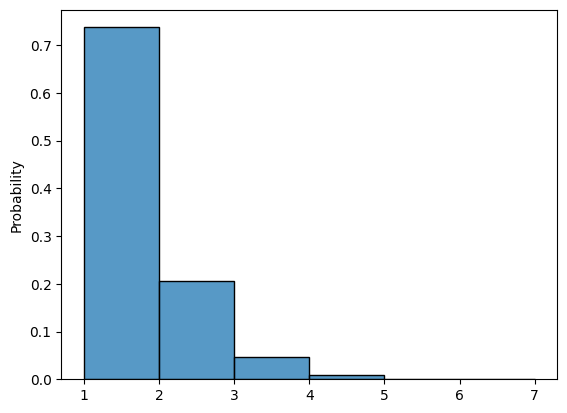

In [9]:
# plot pf-pc
sns.histplot(data=hist_to_list(nonlocal_histogram), binwidth=1, stat='probability')
print(f'Num pf->PC syns: {nonlocal_syn_count}')

Note: Syn count is higher because we have more proofread neurons than the paper

Num local GrC->PC syns: 8579


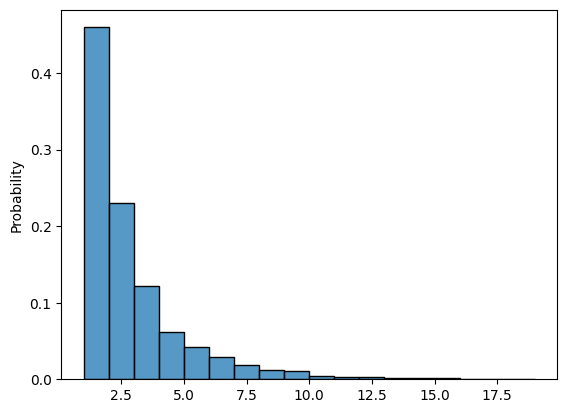

In [10]:
# plot local grc-pc
sns.histplot(data=hist_to_list(local_histogram), binwidth=1, stat='probability')
print(f'Num local GrC->PC syns: {local_syn_count}')

The "local" GrCs are GrCs with cell body within the EM volume and with the ascending axon portion fully constructed. 
The high proportion of single synapse connections is expected as a result of their pf portion making few synapses to the PCs that the asc portion does not reach.

The higher # of syns per connection at the tail is likely due to synapses made by the asc portion.

#### Compute average pf-PC synapses per pf-PC pair

In [11]:
num_pairs = 0
for k, v in nonlocal_histogram.items():
    num_pairs += v
print(f'Average syns per pf-PC pair: {nonlocal_syn_count/num_pairs}')

Average syns per pf-PC pair: 1.3304613535039824


### Analyzing binary GrC-PC connectivity

As an example, we compute the probability of pfs making synapses onto PCs they pass through, reproducing part of Fig. 3c

To analyze the binary graph, we also compute the 'touches', or where two pairs of neurons are nearby each other. These touch db are stored as a dict of grcs/pfs mapped to PCs, with each entry is a tuple of (dist, loc) representing the nearest location where two neurons are nearby.

In [12]:
import compress_pickle
pf_pc_touches = compress_pickle.load('../../analysis/purkinje/db_pf_contacts_201224.gz')
# this db is computed by ../../analysis/purkinje/db_pf_contacts_201224.py
grc_pc_touches = compress_pickle.load('../../analysis/purkinje/grc_pc_touches_210429.gz')
# this db is computed by ../../analysis/purkinje/gen_contacts_grc_210429.py

In [13]:
# filter out newer neurons not available in the touch db or vice versa
touchdb_pfs = set(pf_pc_touches.keys()) & set(remote_grcs)
assert(len(remote_grcs) > 0)

touchdb_pcs = set()
for k,v in pf_pc_touches.items():
    touchdb_pcs |= (set(v.keys()))
touchdb_pcs &= all_pcs
assert(len(touchdb_pcs) > 0)

In [14]:
# make a binary "touch" networkx graph
import networkx as nx
G = nx.DiGraph()
distance_threshold = 160

for pfs in touchdb_pfs:
    G.add_node(pfs)
    for pc, (dist, _) in pf_pc_touches[pfs].items():
        if pc not in touchdb_pcs:
            continue
        G.add_node(pc)
        if dist < distance_threshold:
            G.add_edge(pfs, pc)
            
assert(len(G.edges) > 0)
G_touch_pfs = G

In [15]:
# make a binary "synapse" networkx graph
G = nx.DiGraph()

for pfs in touchdb_pfs:
    G.add_node(pfs)
    for pc in G_remote.adj[pfs]:
        if pc not in touchdb_pcs:
            continue
        G.add_node(pc)
        G.add_edge(pfs, pc)

assert(len(G.edges) > 0)
G_binary_pfs = G

In [16]:
rates = []
threshold = 5  # a pf must touch at least 5 constructed PCs to be counted
for pf in touchdb_pfs:
    pcs = set(G_binary_pfs.successors(pf)) | set(G_touch_pfs.successors(pf))
    if len(pcs) < threshold:
        continue
    rate = len(set(G_binary_pfs.successors(pf))) / len(pcs)
    rates.append(rate)

<Axes: >

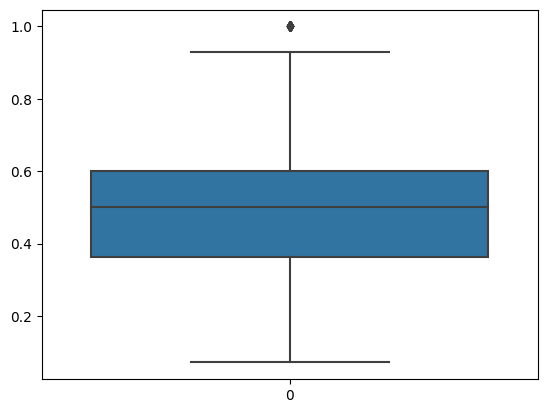

In [17]:
sns.boxplot(rates)